In [1]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import keras
import tensorflow as tf
import PIL

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image

In [2]:
pip install tf-explain --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
from tf_explain.core.grad_cam import GradCAM

In [4]:
#Ignore warnings for a cleaner display
import warnings
warnings.filterwarnings('ignore')

# 1. Data Wrangling <a name='1'></a>

## 1.1 Data Loading <a name='1.1'></a>

**Data Source:** 
But we are currently going to use only the first 35,000 images  as a start then update the model step-by-step due to the size of the data (1 GB). I'm going to focus on two datasets in particular: 
1. **The facial keypoints dataset:** this dataset contains the x- and y-coordinates of the facial images' five keypoints (left eye, right eye, nose, left side of the mouth, and right side of the mouth).
2. **The facial attributes dataset:** this dataset contains 40 attributes that the facial image may have (beard, female, arched eyebrows, eyeglasses, etc.) with `1` denoting that the image contains this attribute and `-1` not.

### 1.1.1 Loading Keypoints Dataset <a name='1.1.1'></a>

In [5]:
#Define paths to keypoints datasets
keypts_data_path = "../input/celeba-dataset/list_landmarks_align_celeba.csv"
images_data_path = "../input/celeba-dataset/img_align_celeba/img_align_celeba"

#Select only 35k images first
img_data_size = 35000

#Original image dimensions
x_og = 178
y_og = 218

# New image dimensions
x_ = 45   
image_size_ratio = x_og / y_og
y_ = int(image_size_ratio * x_)

# Image Sizes
original_image_size = (x_og, y_og)
new_image_size = (x_,y_)

# The image size that will be used in the training process
image_size_training = new_image_size

In [6]:
keypts_og = pd.read_csv(keypts_data_path)[:img_data_size]
keypts_og.sample(5)

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
19990,019991.jpg,67,111,110,113,85,138,66,151,112,149
707,000708.jpg,72,109,104,110,84,133,79,153,99,158
20341,020342.jpg,68,112,110,112,93,137,67,150,110,151
369,000370.jpg,71,110,105,111,96,134,76,154,101,154
30381,030382.jpg,69,112,108,111,84,131,73,152,103,152


In [7]:
keypts_og.describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000
mean,69.368743,111.189143,107.625971,111.153229,88.030029,135.075829,71.282286,152.119200,105.553571,152.215571
std,1.717107,1.128984,1.685886,1.178651,6.702350,4.264796,3.171467,1.795088,3.241235,1.736808
min,60.000000,99.000000,90.000000,99.000000,59.000000,102.000000,60.000000,142.000000,90.000000,139.000000
25%,68.000000,111.000000,107.000000,111.000000,84.000000,133.000000,69.000000,151.000000,103.000000,151.000000
50%,69.000000,111.000000,108.000000,111.000000,88.000000,135.000000,72.000000,152.000000,105.000000,152.000000
75%,70.000000,112.000000,109.000000,112.000000,92.000000,138.000000,74.000000,153.000000,108.000000,153.000000
max,85.000000,121.000000,121.000000,120.000000,120.000000,154.000000,88.000000,168.000000,119.000000,170.000000


In [8]:
keypts_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      35000 non-null  object
 1   lefteye_x     35000 non-null  int64 
 2   lefteye_y     35000 non-null  int64 
 3   righteye_x    35000 non-null  int64 
 4   righteye_y    35000 non-null  int64 
 5   nose_x        35000 non-null  int64 
 6   nose_y        35000 non-null  int64 
 7   leftmouth_x   35000 non-null  int64 
 8   leftmouth_y   35000 non-null  int64 
 9   rightmouth_x  35000 non-null  int64 
 10  rightmouth_y  35000 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 2.9+ MB


In [9]:
keypts_og.shape

(35000, 11)

### 1.1.2 Loading Facial Attributes Dataset <a name='1.1.2'></a>

I will be replacing the `-1` denoting a lack of the attribute to `0` so that the model can learn it as a more categorical variable than ordinal numbers.

In [10]:
#Define paths to facial attributes dataset
attr_data_path = "../input/celeba-dataset/list_attr_celeba.csv"

#Load the first 35,000 of the dataset
attr_og = pd.read_csv(attr_data_path)[:img_data_size]
attr_og.replace(-1, 0, inplace=True)

#Print the shape of the dataframe and check a sample of it
print(attr_og.shape)
attr_og.sample(5)

(35000, 41)


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
6694,006695.jpg,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
24917,024918.jpg,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
22673,022674.jpg,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
9794,009795.jpg,0,0,0,1,0,1,0,1,0,...,0,1,1,0,0,0,0,0,1,1
8413,008414.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,1,0,1,1,0,0,1


In [11]:
attr_og.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,...,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000
mean,0.111200,0.263743,0.513229,0.203800,0.022371,0.153914,0.239057,0.236943,0.241143,0.146800,...,0.057343,0.475686,0.209371,0.316629,0.186200,0.049514,0.467886,0.120229,0.073886,0.780571
std,0.314384,0.440668,0.499832,0.402828,0.147890,0.360872,0.426514,0.425213,0.427783,0.353911,...,0.232500,0.499416,0.406866,0.465168,0.389274,0.216942,0.498975,0.325233,0.261589,0.413865
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
attr_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image_id             35000 non-null  object
 1   5_o_Clock_Shadow     35000 non-null  int64 
 2   Arched_Eyebrows      35000 non-null  int64 
 3   Attractive           35000 non-null  int64 
 4   Bags_Under_Eyes      35000 non-null  int64 
 5   Bald                 35000 non-null  int64 
 6   Bangs                35000 non-null  int64 
 7   Big_Lips             35000 non-null  int64 
 8   Big_Nose             35000 non-null  int64 
 9   Black_Hair           35000 non-null  int64 
 10  Blond_Hair           35000 non-null  int64 
 11  Blurry               35000 non-null  int64 
 12  Brown_Hair           35000 non-null  int64 
 13  Bushy_Eyebrows       35000 non-null  int64 
 14  Chubby               35000 non-null  int64 
 15  Double_Chin          35000 non-null  int64 
 16  Eyeg

### 1.1.3 Images Data
Loading the images data involves converting it to arrays so it may be used it in training the model.

In [13]:
images = []

for idx in range(keypts_og.shape[0]):
    #Retrieve path
    path = "{}/{}".format(str(images_data_path), str(keypts_og.iloc[idx].image_id))
    
    #Reading images
    image = PIL.Image.open(path).resize(image_size_training)
    image_array = np.asarray(image) / 255
    
    #Append images
    images.append(image_array)

In [14]:
#Convert to array
images = np.array(images)

images.shape

(35000, 36, 45, 3)

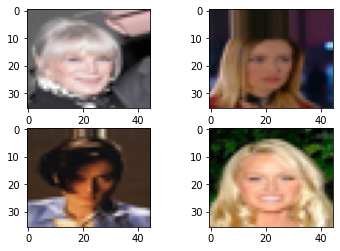

In [15]:
#Plotting sample images
idx1, idx2, idx3, idx4 = np.random.randint(0, 5000, size=4)

fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(images[idx1])
axs[1,0].imshow(images[idx2])
axs[1,1].imshow(images[idx3])
axs[0,1].imshow(images[idx4])
plt.show()

## 1.2 Data Cleaning <a name='1.2'></a>
There isn't much to clean in the data since I would like the deep learning to obtain as much of the raw data as possible. However, I will check for any missing values.

In [16]:
#Check for missing values in keypoints dataset
keypts_og.isnull().sum()

image_id        0
lefteye_x       0
lefteye_y       0
righteye_x      0
righteye_y      0
nose_x          0
nose_y          0
leftmouth_x     0
leftmouth_y     0
rightmouth_x    0
rightmouth_y    0
dtype: int64

In [17]:
#Check for missing values in attributes dataset
attr_og.isnull().sum()

image_id               0
5_o_Clock_Shadow       0
Arched_Eyebrows        0
Attractive             0
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             0
Blond_Hair             0
Blurry                 0
Brown_Hair             0
Bushy_Eyebrows         0
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           0
High_Cheekbones        0
Male                   0
Mouth_Slightly_Open    0
Mustache               0
Narrow_Eyes            0
No_Beard               0
Oval_Face              0
Pale_Skin              0
Pointy_Nose            0
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              0
Smiling                0
Straight_Hair          0
Wavy_Hair              0
Wearing_Earrings       0
Wearing_Hat            0
Wearing_Lipstick       0
Wearing_Necklace       0
Wearing_Necktie        0


# 2. EDA
In order to take an initial closer look at the dataset, I want to take a look at the following:
1. Distribution of the keypoints coordinates
2. Visualization of the facial attributes

## 2.1 Distribution of the Keypoints Coordinates <a name='2.1'></a>
Since the images dataset is already cropped into nice images with the face roughly centered, I would expect the coordinates to be roughly concentrated around particular areas; for example, the right eye coordinates would be expected to mostly be in the right upper quadrant. If this is not the case, there could be transformed or different types of facial images in the dataset.

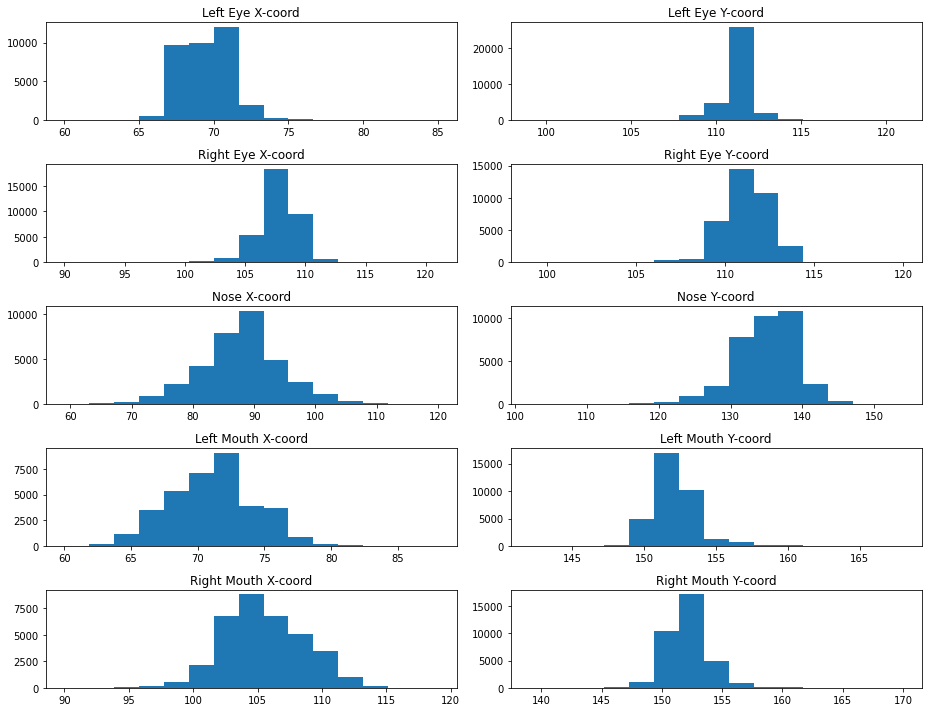

In [18]:
#Plotting distribution of the keypoints' coordinates
fig, axs = plt.subplots(5, 2, figsize=(13,10))

#Left eye
axs[0,0].hist(keypts_og.lefteye_x, bins=15)
axs[0,0].set_title('Left Eye X-coord')
axs[0,1].hist(keypts_og.lefteye_y, bins=15)
axs[0,1].set_title('Left Eye Y-coord')

#Right eye
axs[1,0].hist(keypts_og.righteye_x, bins=15)
axs[1,0].set_title('Right Eye X-coord')
axs[1,1].hist(keypts_og.righteye_y, bins=15)
axs[1,1].set_title('Right Eye Y-coord')

#Nose
axs[2,0].hist(keypts_og.nose_x, bins=15)
axs[2,0].set_title('Nose X-coord')
axs[2,1].hist(keypts_og.nose_y, bins=15)
axs[2,1].set_title('Nose Y-coord')

#Left mouth
axs[3,0].hist(keypts_og.leftmouth_x, bins=15)
axs[3,0].set_title('Left Mouth X-coord')
axs[3,1].hist(keypts_og.leftmouth_y, bins=15)
axs[3,1].set_title('Left Mouth Y-coord')

#Right mouth
axs[4,0].hist(keypts_og.rightmouth_x, bins=15)
axs[4,0].set_title('Right Mouth X-coord')
axs[4,1].hist(keypts_og.rightmouth_y, bins=15)
axs[4,1].set_title('Right Mouth Y-coord')

plt.tight_layout()
plt.show()

To add more visual context of where these coordinates lie:

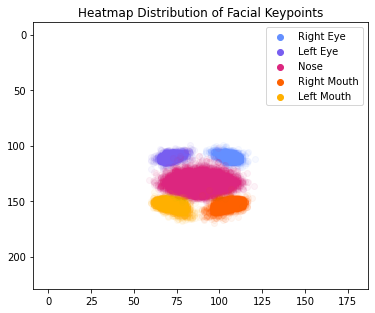

In [19]:
#Plot a sample box of with a heatmap of where the coordinates are
fig, ax = plt.subplots(figsize=(6,6*image_size_ratio))

rect = patches.Rectangle((0, 0), 178, -218, linewidth=4, facecolor='none')
ax.add_patch(rect)

#Add scatter plots of the coordinates with colorblind friendly colors
ax.scatter(keypts_og.righteye_x, -keypts_og.righteye_y, alpha=0.05, color='#648FFF', label='Right Eye')
ax.scatter(keypts_og.lefteye_x, -keypts_og.lefteye_y, alpha=0.05, color='#785EF0', label='Left Eye')
ax.scatter(keypts_og.nose_x, -keypts_og.nose_y, alpha=0.05, color='#DC267F', label='Nose')
ax.scatter(keypts_og.rightmouth_x, -keypts_og.rightmouth_y, alpha=0.05, color='#FE6100', label='Right Mouth')
ax.scatter(keypts_og.leftmouth_x, -keypts_og.leftmouth_y, alpha=0.05, color='#FFB000', label='Left Mouth')
#ax.scatter(105,153,color='black')

#Add legend for the colors
leg = ax.legend()
#Set legend opacity colors to opaque (1)
for lh in leg.legendHandles:
    lh.set_alpha(1)

#Display positive y-ticks
ax.get_yaxis().set_ticklabels([250, 200, 150, 100, 50, 0])
    
plt.title('Heatmap Distribution of Facial Keypoints')
plt.show()

## 2.2 Boxplot of Facial Attributes <a name='2.2'></a>
This would give me a better idea of the how the facial attributes are distributed within the dataset since it's a categorical variable of `0` and `1`. I'll be plotting:
1. Barplot to see how many of each there are
2. Heatmap for any correlations between attributes

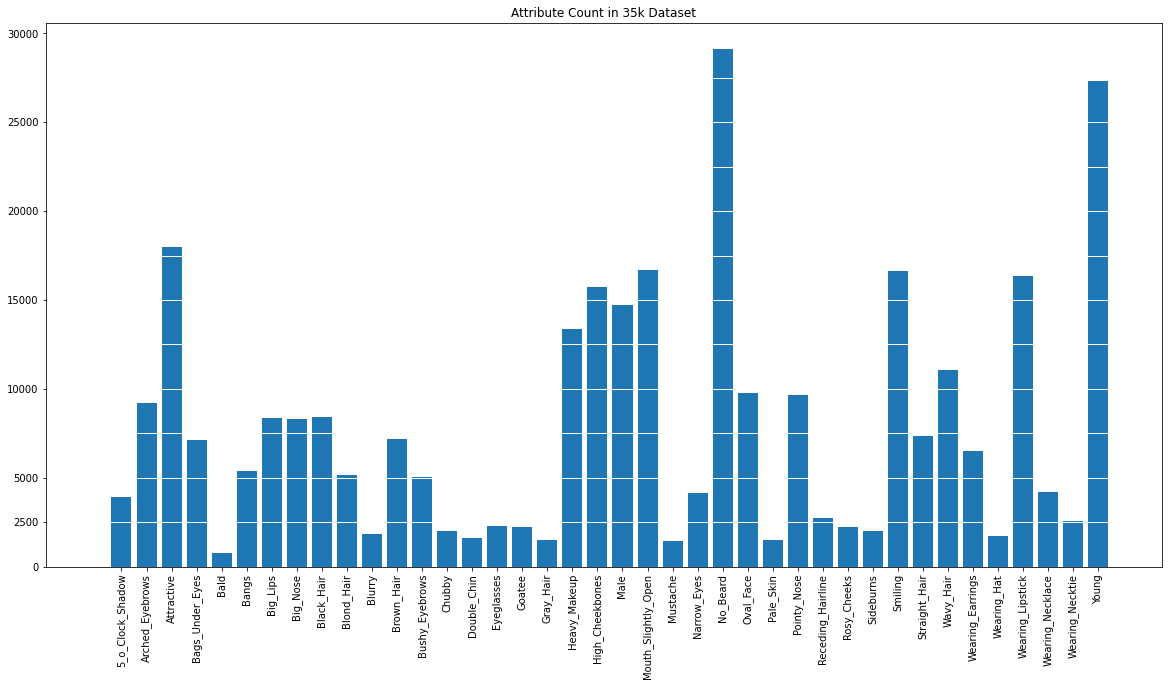

In [20]:
#Visualize attribute count
count = pd.DataFrame(attr_og.iloc[:,1:].sum(axis=0))
count.columns = ['attr']

#Plot the attributes count
plt.subplots(figsize=(20,10))

plt.bar(count.index, count['attr'])

#Add indicator lines
plt.hlines(y=np.arange(0,30000,2500), xmin=-1, xmax=39.5, linewidth=1, color='white')

plt.title('Attribute Count in 35k Dataset')
plt.xticks(rotation=90)
plt.yticks(np.append(2500, np.arange(0,35000,5000)), labels=np.append(2500, np.arange(0,35000,5000)))

plt.show()

Heatmap plotted to check for any correlations between attributes. I would expect attributes like `5_o_Clock_Shadow` to be well correlated with `Male` and `No_Beard`.

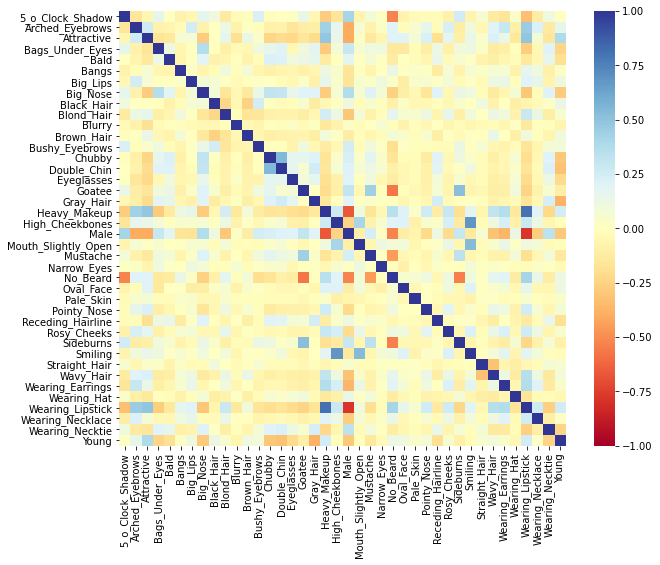

In [21]:
#Correlation map
corrmap = attr_og.iloc[:,1:].corr()

#Plot heatmap of attributes
plt.subplots(figsize=(10, 8))
sns.heatmap(corrmap, cmap='RdYlBu', vmin=-1, vmax=1)
plt.show()

In [22]:
#Take a closer look at the ones correlated
threshold = 0.5

some_corr = corrmap[(corrmap > threshold) | (corrmap < -threshold)]
cols = some_corr.columns

for col in cols:
    for row in cols:
        if ~(np.isnan(some_corr.loc[row,col])):
            if row != col:
                print('{:.3f}: {}, {}'.format(some_corr.loc[row, col], row, col))

-0.529: No_Beard, 5_o_Clock_Shadow
0.541: Double_Chin, Chubby
0.541: Chubby, Double_Chin
-0.568: No_Beard, Goatee
0.516: Sideburns, Goatee
-0.665: Male, Heavy_Makeup
0.805: Wearing_Lipstick, Heavy_Makeup
0.682: Smiling, High_Cheekbones
-0.665: Heavy_Makeup, Male
-0.524: No_Beard, Male
-0.789: Wearing_Lipstick, Male
0.535: Smiling, Mouth_Slightly_Open
-0.529: 5_o_Clock_Shadow, No_Beard
-0.568: Goatee, No_Beard
-0.524: Male, No_Beard
-0.544: Sideburns, No_Beard
0.516: Goatee, Sideburns
-0.544: No_Beard, Sideburns
0.682: High_Cheekbones, Smiling
0.535: Mouth_Slightly_Open, Smiling
0.805: Heavy_Makeup, Wearing_Lipstick
-0.789: Male, Wearing_Lipstick


### Helper Functions

In [23]:
#Read image based on index
def imread_index(index, size=image_size_training, path=images_data_path):
    """This function helps read images based on the its index by converting it to an array.
    """
    path = "{}/{}".format(str(path), str(keypts_og.iloc[index].image_id))
    
    #read the image
    image = PIL.Image.open(path).resize(size)
    image_array = np.asarray(image)
    
    return image_array

In [24]:
#Get a list of all key points of the face
def img_keypts_list(index, df=keypts_og):
    """ This function returns a list of all the key points of the face image so 
    it's easier to plot
    """
    points_list = [df.iloc[index].lefteye_x, df.iloc[index].lefteye_y,
                  df.iloc[index].righteye_x, df.iloc[index].righteye_y,
                  df.iloc[index].nose_x, df.iloc[index].nose_y,
                  df.iloc[index].leftmouth_x, df.iloc[index].leftmouth_y,
                  df.iloc[index].rightmouth_x, df.iloc[index].rightmouth_y]
    
    return points_list

In [25]:
#Plot image with green bounding box and keypoints
def plot_face_bbox(index, df=keypts_og, size=original_image_size):
    """ This function plots the face image with its keypoints and bounding box
    """
    img = imread_index(index, size)
    points_list = img_keypts_list(index, df)
    
    #Plotting the image
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    #Plot the face points
    ax.plot(points_list[::2], points_list[1::2], 'bo-')
    
    #Plot bounding box
    width = abs(points_list[0] - points_list[8] - 60) #obtain width from left eye x to right mouth x
    height = abs(points_list[1] - points_list[9] - 75)#obtain width from left eye y to right mouth y
    rect = patches.Rectangle((points_list[0]-30, points_list[1]-40), width, height, linewidth=4, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    
    #Remove axis
    plt.axis('off')
    plt.show()

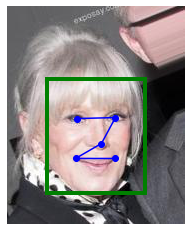

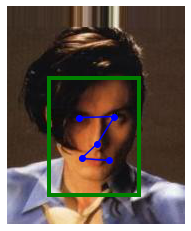

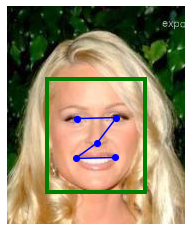

In [26]:
#test
#idx1, idx2, idx3 = np.random.randint(0, 35000, size=3)

#Test plotting sample images
plot_face_bbox(idx1)
plot_face_bbox(idx2)
plot_face_bbox(idx3)

Since the image sizes were scaled down, the key points also need to be rescaled.

In [27]:
#Copy the original dataframe to leave it intact
keypts = keypts_og.copy()

x_old, y_old = original_image_size
x_new, y_new = image_size_training

#Get ratio of new to old for rescaling
x_ratio = x_new / x_old
y_ratio = y_new / y_old

keypts_x = ['lefteye_x', 'righteye_x', 'nose_x', 'leftmouth_x', 'rightmouth_x']
keypts_y = ['lefteye_y', 'righteye_y', 'nose_y', 'leftmouth_y', 'rightmouth_y']

#Rescale the keypoints
keypts[keypts_x] = (keypts[keypts_x] * x_ratio).astype('int')
keypts[keypts_y] = (keypts[keypts_y] * y_ratio).astype('int')

In [28]:
#Check keypoints to see if rescaled
keypts.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,17,18,26,18,19,23,18,25,27,25
1,000002.jpg,17,18,27,18,20,22,17,24,27,25
2,000003.jpg,19,18,26,17,27,21,18,25,24,26
3,000004.jpg,18,18,27,17,25,22,17,25,25,24
4,000005.jpg,16,18,28,18,21,19,17,24,26,24


### Split data into training and test datasets

In [29]:
# training data
train_labels = keypts[:img_data_size - 5000]
train_images = images[:img_data_size - 5000]


# test data (1000 sample)
test_labels = keypts[img_data_size - 5000 + 1:]
test_images = images[img_data_size - 5000 + 1:]

### Train and Validation Sets

In [30]:
#Dropping image_id column
y = train_labels.drop(['image_id'], axis = 1) 
X = train_images

# check
y.head(3)

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,17,18,26,18,19,23,18,25,27,25
1,17,18,27,18,20,22,17,24,27,25
2,19,18,26,17,27,21,18,25,24,26


In [31]:
#Split the data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state = 42)

#Check the ratio
X_val.shape[0]/X_train.shape[0]

0.25

### Building and Training the Model

In [32]:
#Img dimensions
x_ = image_size_training[0]
y_ = image_size_training[1]

#Building the model
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', input_shape=(y_, x_, 3)))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='relu'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 45, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 45, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 22, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 22, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 22, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 22, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 11, 16)         0

In [34]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [35]:
#Fit model 
training_process = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size=300, shuffle=True)

Epoch 1/200
80/80 [==============================] - 25s 303ms/step - loss: 308.0057 - accuracy: 0.4793 - val_loss: 169.4783 - val_accuracy: 0.9047
Epoch 2/200
80/80 [==============================] - 23s 292ms/step - loss: 135.0552 - accuracy: 0.3560 - val_loss: 151.5305 - val_accuracy: 0.9047
Epoch 3/200
80/80 [==============================] - 23s 294ms/step - loss: 96.2868 - accuracy: 0.3708 - val_loss: 77.3900 - val_accuracy: 0.9047
Epoch 4/200
80/80 [==============================] - 23s 291ms/step - loss: 40.5636 - accuracy: 0.4202 - val_loss: 69.7324 - val_accuracy: 0.9047
Epoch 5/200
80/80 [==============================] - 23s 288ms/step - loss: 32.4477 - accuracy: 0.4111 - val_loss: 79.4286 - val_accuracy: 0.9047
Epoch 6/200
80/80 [==============================] - 23s 292ms/step - loss: 28.1949 - accuracy: 0.4239 - val_loss: 64.1952 - val_accuracy: 0.9047
Epoch 7/200
80/80 [==============================] - 23s 292ms/step - loss: 26.3302 - accuracy: 0.4392 - val_loss: 47.06

### Testing the Model

In [36]:
# function to plot the image with green box around the faces
def plot_test_img(index, model, pred_or_actual = 'pred', pointsColor='ro-', boxcolor='g'):
    img = tf.keras.preprocessing.image.load_img("{}/00{}.jpg".format(images_data_path, index),target_size=(y_og,x_og,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    test_image = img/255
    model = model
    
    #Obtain predictions for key points of face
    if pred_or_actual == 'pred':
        img = tf.keras.preprocessing.image.load_img("{}/00{}.jpg".format(images_data_path, index),target_size=(y_,x_,3))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img/255
        
        points_list = model.predict(img.reshape(1,y_,x_,3)).astype('int')[0]
        
        #convert key pts values to original size
        x_ratio = 1.05 * (original_image_size[0] / image_size_training[0])
        y_ratio = 1.085 * (original_image_size[1] / image_size_training[1])
        
        points_list[0] = int(points_list[0] * x_ratio)
        points_list[2] = int(points_list[2] * x_ratio)
        points_list[4] = int(points_list[4] * x_ratio)
        points_list[6] = int(points_list[6] * x_ratio)
        points_list[8] = int(points_list[8] * x_ratio)
    
        points_list[1] = int(points_list[1] * y_ratio)
        points_list[3] = int(points_list[3] * y_ratio)
        points_list[5] = int(points_list[5] * y_ratio)
        points_list[7] = int(points_list[7] * y_ratio)
        points_list[9] = int(points_list[9] * y_ratio)
        
        title = 'Predicted'
        
    elif pred_or_actual == 'actual':      
        points_list = img_keypts_list(index)
        pointsColor = 'bo-'
        title = 'Actual'
    
    # face points
    le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
    n_x, n_y = points_list[4], points_list[5]
    lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]

    # Create figure and axes
    fig, ax = plt.subplots()
    # plot the image
    ax.imshow(test_image)
    # plot the points on the face
    ax.plot([le_x,re_x,n_x,lm_x,rm_x], [le_y,re_y,n_y,lm_y,rm_y], pointsColor)
    ax.set_title(title)
    
    # plot the box around the face
    width = abs(le_x-rm_x-60)
    height = abs(le_y-rm_y-75)
    rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor=boxcolor, facecolor='none')
    ax.add_patch(rect);
    return points_list

In [37]:
#Load trained model from previous commits to save time
#model = keras.models.load_model('my_model')

In [38]:
#Load trained model from previous commits to save time
#model = keras.models.load_model('../input/face-classification/model.h5')

[70, 111, 107, 111, 91, 136, 71, 153, 105, 152]

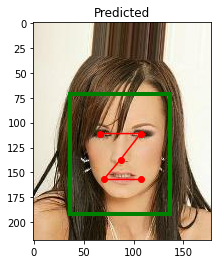

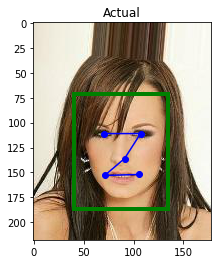

In [39]:
index = 4100
plot_test_img(index, model, pred_or_actual = 'pred')
plot_test_img(index, model, pred_or_actual='actual')

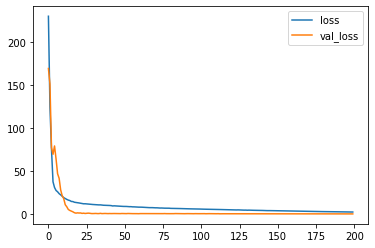

In [40]:
# losses of both training and validation sets
loss = training_process.history['loss']
val_loss = training_process.history['val_loss']

# plot both losses
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss']);

In [41]:
# saving the model as SavedModel format
model.save('my_model')

# Explainability of the model

Instead of blindly trusting the 'black box,' I'm going to be delving further into what is going on under the hood to make sure there's some explainability to the model.

In [42]:
#Take a random image from the dataset
IDX = 25600

path = "{}/{}".format(str(images_data_path), str(keypts_og.iloc[IDX].image_id))
im = PIL.Image.open(path).resize(image_size_training)
im_array = np.asarray(im)

im = np.asarray(im).reshape(-1, 36, 45, 3)
im.shape

(1, 36, 45, 3)

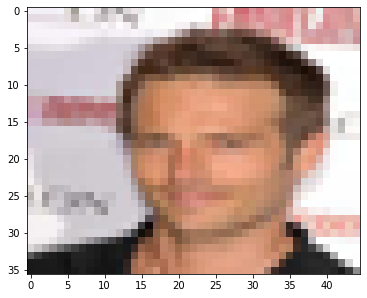

In [43]:
fig = plt.figure(figsize=(6,6*image_size_ratio))
plt.imshow(im_array/255)
plt.show()

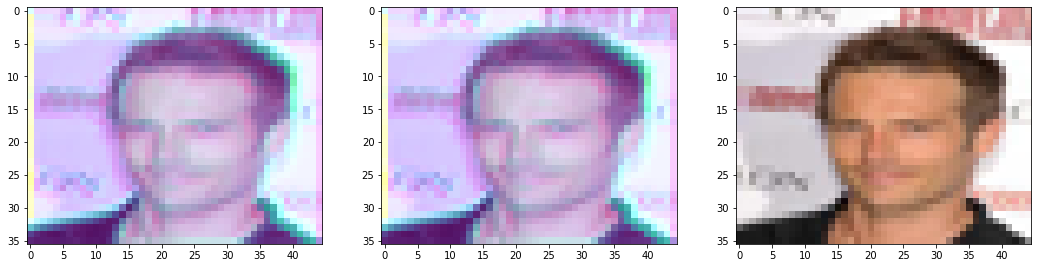

In [44]:
#Visualize GradCAM output from 1st conv layer
explainer = GradCAM()

grid1 = explainer.explain((im, None), model, 1, 'conv2d')
grid2 = explainer.explain((im, None), model, 4, 'conv2d')

#Plot the visualizations
fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im_array / 255.)
ax1.imshow(grid1, alpha=1)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im_array / 255.)
ax2.imshow(grid2, alpha=1)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(im_array / 255.)

The model is looking at the edges and outlines of the shapes, which makes sense since it's looking at one of its early layers. Going deeper into the CNN model, however, gives more model explainability.

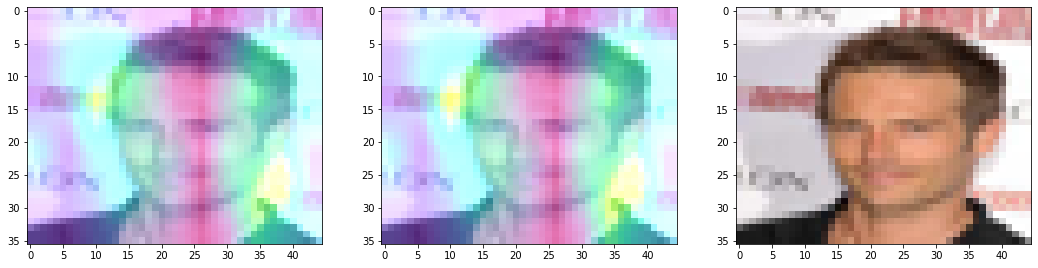

In [45]:
#Visualize GradCAM output from 4th conv layer
grid1 = explainer.explain((im, None), model, 1, 'conv2d_4')
grid2 = explainer.explain((im, None), model, 4, 'conv2d_4')

#Plot the visualizations
fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im_array / 255.)
ax1.imshow(grid1, alpha=1)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im_array / 255.)
ax2.imshow(grid2, alpha=1)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(im_array / 255.)

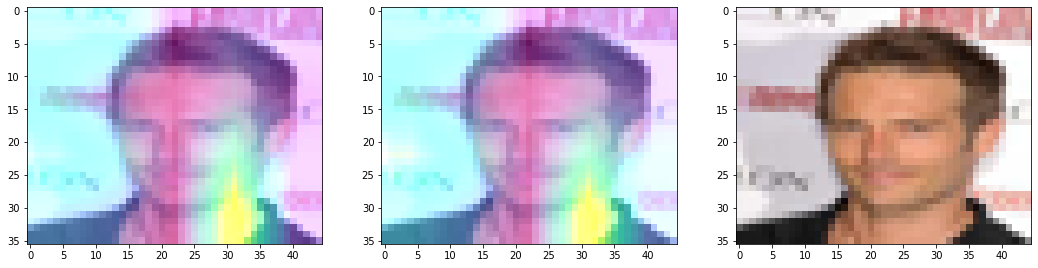

In [46]:
#Visualize GradCAM output from last conv layer
grid1 = explainer.explain((im, None), model, 1, 'conv2d_5')
grid2 = explainer.explain((im, None), model, 4, 'conv2d_5')

#Plot the visualizations
fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im_array / 255.)
ax1.imshow(grid1, alpha=1)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im_array / 255.)
ax2.imshow(grid2, alpha=1)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(im_array / 255.)